# ACSE-9 Independent Research Project
## Evaluating the Changes in Temporal Dynamics of Climate Variables and Wildfires in Pantanal of Tropical South America
### Notebook version
#### Please upload "training_set.csv" file in the repository before excute any cell

In [1]:
R.version.string

[1] "R version 4.1.1 (2021-08-10)"

In [2]:
install.packages('corrplot')
install.packages('Hmisc')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘htmlwidgets’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’




In [3]:
library(corrplot)
library("Hmisc")

corrplot 0.90 loaded

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




## Read data and display first two rows of data

In [4]:
data <- read.csv("training_set.csv",header=TRUE)
head(data, n = 1)

,id,prec,srad,tavg,vapr,wind,FRP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,80,59.08333,14527.58,24.99167,2.111667,2.283333,65.4


## Run a correlation test for selected variables

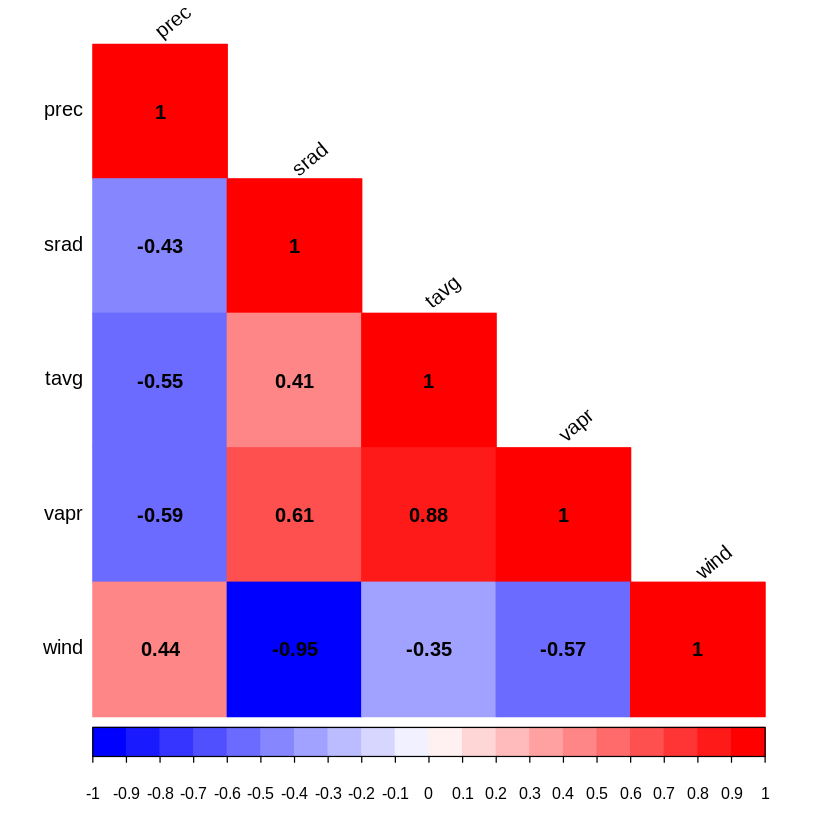

In [5]:
cor_data <- cor(data[, 2:6])
corr <- cor_data
col2 = colorRampPalette(c('blue', 'white', 'red'))  
par(mfrow= c(1,1))
corrplot(corr, method = 'color', type = 'lower', order = 'alphabet', 
         tl.col = 'black', addCoef.col = 'black',
         cl.ratio = 0.2, tl.srt = 40, col = col2(20))

## vapour and wind variables are highliy correlated to tmeperature and solar radiation. So, we need to remove data from vapour and wind. Apply correlation test again 

In [8]:
data <- data[, -c(5,6)]
cor_data <- cor(data[, 2:4])
cor_data

,prec,srad,tavg
prec,1.0000000,-0.4262766,-0.5517619
srad,-0.4262766,1.0000000,0.4131335
tavg,-0.5517619,0.4131335,1.0000000


In [7]:
head(data, n = 2)

,id,prec,srad,tavg,FRP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,80,59.08333,14527.58,24.99167,65.4
2,81,59.16667,14543.33,25.03333,10.4


## Classify fire category by FRP

In [9]:
FireBand <-ifelse(data$FRP>1500, 4, data$FRP)
FireBand <-ifelse(1500>=data$FRP & data$FRP>1000, 3, FireBand)
FireBand <-ifelse(1000>=data$FRP & data$FRP>500, 2, FireBand)
FireBand <-ifelse(500>=data$FRP & data$FRP>100, 1, FireBand)
FireBand <-ifelse(100>=data$FRP & data$FRP>=0, 0, FireBand)

dataclass <- data.frame(data[, 1:4], FireBand)

In [10]:
head(dataclass,2)

,id,prec,srad,tavg,FireBand
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,80,59.08333,14527.58,24.99167,0
2,81,59.16667,14543.33,25.03333,0


 ## Create lists to store model information

In [11]:
Model<- c()
Accuracy <- c()
ErrorRate <- c()
FPR_0 <- c()
FPR_1 <- c()
FPR_2 <- c()
FPR_3 <- c()
FPR_4 <- c()

# Classification
## Decision Tree

In [12]:
install.packages('rattle')
install.packages('rpart')
install.packages('pROC')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘XML’, ‘rpart.plot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [13]:
library('rattle')
library('rpart')
library('pROC')

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [14]:
set.seed(0465)
datatree <- dataclass

## Split train and test sets

In [15]:
nrows <- nrow(datatree)
trainset <- sample(1:nrows, .80*nrows)
testset <- setdiff(1:nrows, trainset)
traintree <- datatree[trainset,]
testtree <- datatree[testset,]

## Build a decision tree model for training

In [16]:
control <- rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001)
tree.fire <- rpart(FireBand ~ ., data = traintree,
                    method = 'class', parms = list(split = "information"),
                    control = control)


## Check the information of the model

In [17]:
tree.fire

n= 78003 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

         1) root 78003 8882 0 (0.89 0.11 0.0041 0.00072 0.00041)  
           2) srad>=14261.44 60631 6147 0 (0.9 0.097 0.0032 0.00058 0.00026)  
             4) srad< 14630.3 28936 2063 0 (0.93 0.069 0.0015 0.00024 0.0001)  
               8) id>=162376.5 21185 1235 0 (0.94 0.057 0.0013 0.00019 0)  
                16) tavg>=23.07986 19707  992 0 (0.95 0.049 0.00086 5.1e-05 0)  
                  32) srad< 14553.94 14626  648 0 (0.96 0.044 0.00048 0 0)  
                    64) tavg>=23.225 13631  565 0 (0.96 0.041 0.00051 0 0) *
                    65) tavg< 23.225 995   83 0 (0.92 0.083 0 0 0)  
                     130) id>=239601 737   40 0 (0.95 0.054 0 0 0)  
                       260) id< 292283.5 515   13 0 (0.97 0.025 0 0 0) *
                       261) id>=292283.5 222   27 0 (0.88 0.12 0 0 0)  
                         522) prec< 62.97917 212   22 0 (0.9 0.1 0 0 0)  
                          1

In [18]:
head(tree.fire$cptable, 10)

,CP,nsplit,rel error,xerror,xstd
1,0.0002384201,0,1.0000000,1.000000,0.009988355
2,0.0002251745,45,0.9862644,1.004616,0.010008412
3,0.0002026571,75,0.9790588,1.006080,0.010014758
4,0.0001930067,80,0.9780455,1.009007,0.010027429
5,0.0001876454,94,0.9742175,1.011259,0.010037157
6,0.0001688809,107,0.9711777,1.019252,0.010071565
7,0.0001594986,155,0.9629588,1.035240,0.010139789
8,0.0001576222,236,0.9468588,1.039068,0.010156008
9,0.0001558900,241,0.9460707,1.039518,0.010157913
10,0.0001548075,264,0.9417924,1.042671,0.010171233


## We can see from 'cptable', when cp=0.000238, x-val relative error has the nimimum value "1.0". We'll set cp=0.000238 to prune the decision tree

In [19]:
CP <- 0.000238
prunedtree <- prune(tree.fire, cp = CP)

## Evaluate model

In [ ]:
prunedtree.preds <- predict(prunedtree, newdata = testtree, type = 'class')
err_list <- table(testtree$FireBand, prunedtree.preds, dnn=c("Observed", "Predicted"))
err_list

        Predicted
Observed    0    1    2    3    4
       0 4803  344   12    1    4
       1  593  121    4    0    0
       2   14    5    0    0    0
       3    3    0    0    0    0
       4    2    0    0    0    0

## Calculate accuracy for each category

In [ ]:
Model[1]<- 'Decision Tree'
Accuracy[1] <- (sum(diag(err_list)))/sum(err_list)
ErrorRate[1] <- 1 - Accuracy[1]
FPR_0[1] <- (err_list[1,2]+err_list[1,3]+err_list[1,4]+err_list[1,5])/sum(err_list[1,])
FPR_1[1] <- (err_list[2,1]+err_list[2,3]+err_list[2,4]+err_list[2,5])/sum(err_list[2,])
FPR_2[1] <- (err_list[3,1]+err_list[3,2]+err_list[3,4]+err_list[4,5])/sum(err_list[3,])
FPR_3[1] <- (err_list[4,1]+err_list[4,2]+err_list[4,3]+err_list[4,5])/sum(err_list[4,])
FPR_4[1] <- (err_list[5,1]+err_list[5,2]+err_list[5,3]+err_list[5,4])/sum(err_list[5,])

## Random Forest

In [ ]:
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library('randomForest')

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:rattle’:

    importance


The following object is masked from ‘package:ggplot2’:

    margin




## Build a random forest model with ntree=500, mtry=1


In [ ]:
model <- randomForest(as.factor(FireBand) ~ .,
                            data=traintree,
                            ntree=500,mtry=1,
                            importance=TRUE, 
                            na.action=na.roughfix,
                            replace=TRUE)

In [ ]:
print(model)


Call:
 randomForest(formula = as.factor(FireBand) ~ ., data = traintree,      ntree = 500, mtry = 1, importance = TRUE, replace = TRUE,      na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 12.92%
Confusion matrix:
      0   1 2 3 4 class.error
0 20338 307 1 0 0  0.01491814
1  2627 234 3 0 0  0.91829609
2    79  11 0 0 0  1.00000000
3    14   2 0 0 0  1.00000000
4     8   0 0 0 0  1.00000000


In [ ]:
head(dataclass, n = 10)

,id,prec,srad,tavg,FireBand
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,80,59.08333,14527.58,24.99167,0
2,81,59.16667,14543.33,25.03333,0
3,82,59.08333,14544.67,25.05833,0
4,84,58.75000,14519.25,25.16667,0
5,85,58.75000,14537.08,25.15000,0
6,814,58.16667,14573.67,25.15000,0
7,815,58.50000,14544.44,25.15556,0
8,817,59.12500,14506.62,25.05417,0
9,818,59.20833,14525.75,25.02083,0


## Now, let's run a validation process to find the best values for 'ntree' and 'ntry'

In [ ]:
ntree_list <- c(50,100,500,1000)
ntry_list <- c(1,2,3)
min.ntree <- c()
OBB.err <- c()

In [ ]:
for(ntree in ntree_list){
  for (ntry in ntry_list ){
    model.RandomForest <- randomForest(as.factor(FireBand) ~ .,
                                       data=traintree, 
                                       ntree=ntree, mtry=ntry,
                                       importance=TRUE, 
                                       na.action=na.roughfix,
                                       replace=TRUE)
    a <- which(model.RandomForest$err.rate[,"OOB"]== min(model.RandomForest$err.rate[,"OOB"]))[1]
    b <- model.RandomForest$err.rate[which(model.RandomForest$err.rate[,"OOB"] 
                                                  == min(model.RandomForest$err.rate[,"OOB"]))[1]]
    cat("ntry:", ntry, " ")
    cat("ntree:", a, ", ")
    cat("xerror:", b, "  ;")
    
    }
}


ntree: 50ntry: 0.1208671ntree: 50ntry: 0.1239824ntree: 50ntry: 0.1246875ntree: 99ntry: 0.1186236ntree: 93ntry: 0.1220979ntree: 99ntry: 0.122803ntree: 215ntry: 0.1172263ntree: 393ntry: 0.1193928ntree: 375ntry: 0.1211107ntree: 730ntry: 0.116957ntree: 823ntry: 0.1194954ntree: 968ntry: 0.1204441

In [ ]:
# ntree: 50  ntry: 0.1208671
# ntree: 50 ntry: 0.1239824
# ntree: 50 ntry: 0.1246875
# ntree: 99 ntry: 0.1186236
# ntree: 93 ntry: 0.1220979
# ntree: 99 ntry: 0.122803
# ntree: 215  ntry: 0.1172263
# ntree: 393  ntry: 0.1193928
# ntree: 375  ntry: 0.1211107
# ntree: 730  ntry: 0.116957
# ntree: 823  ntry: 0.1194954
# ntree: 968  ntry: 0.1204441

## We found our model with the best performance when "ntree" = 730, "mtry" = 1

In [ ]:
model.final <- randomForest(as.factor(FireBand) ~ .,
                         data=traintree, 
                         ntree=730, mtry=1,
                         importance=TRUE, 
                         na.action=na.roughfix,
                         replace=TRUE)


## Print the importance for variables

In [ ]:
importance_variable <- round(model.final$importance, 4)
importance_variable[-1,]

,0,1,2,3,4,MeanDecreaseAccuracy,MeanDecreaseGini
prec,0.0887,-0.0161,0.0066,-6e-04,0.0812,0.0756,1104.650
srad,0.0504,0.0057,0.0062,1e-04,0.0606,0.0448,1352.614
tavg,0.0717,-0.0051,0.0092,-2e-03,0.0745,0.0621,1169.017


## Evaluate model


In [ ]:
random.preds <- predict(model.final, newdata = testtree, type = 'class')
err_list <- table(testtree$FireBand, random.preds,dnn=c("Observed", "Predicted"))
err_list

        Predicted
Observed    0    1    2    3    4
       0 5075   88    1    0    0
       1  673   45    0    0    0
       2   18    1    0    0    0
       3    3    0    0    0    0
       4    2    0    0    0    0

## Calculate the rates of accuracy


In [ ]:
Model[2]<- 'Random Forest'
Accuracy[2]  <- (sum(diag(err_list)))/sum(err_list) 
ErrorRate[2] <- 1 - Accuracy[2] 
FPR_0[2] <- (err_list[1,2]+err_list[1,3]+err_list[1,4]+err_list[1,5])/sum(err_list[1,])
FPR_1[2] <- (err_list[2,1]+err_list[2,3]+err_list[2,4]+err_list[2,5])/sum(err_list[2,])
FPR_2[2] <- (err_list[3,1]+err_list[3,2]+err_list[3,4]+err_list[4,5])/sum(err_list[3,])
FPR_3[2] <- (err_list[4,1]+err_list[4,2]+err_list[4,3]+err_list[4,5])/sum(err_list[4,])
FPR_4[2] <- (err_list[5,1]+err_list[5,2]+err_list[5,3]+err_list[5,4])/sum(err_list[5,])


## The predicting accuracy for each category in each model:

In [ ]:
OVERALL <-  data.frame(Model, Accuracy, ErrorRate,FPR_0,FPR_1,
                       FPR_2,FPR_3,FPR_4)

In [ ]:
OVERALL

## Let's plot AUC - ROC Curve

In [ ]:
install.packages('ROCR')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’




In [ ]:
library(ROCR)

Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls > cases



Multi-class area under the curve: 0.6974

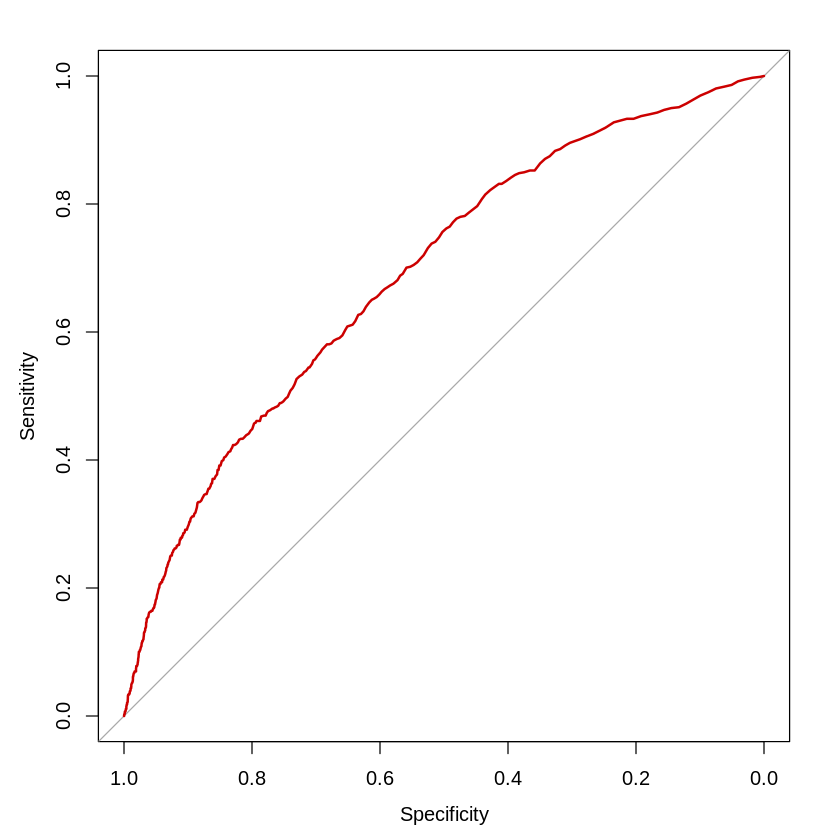

In [ ]:
par(mfrow= c(1,1))
roc.pred <- predict(model.final, testtree,type="prob")

ran_roc <- multiclass.roc(testtree$FireBand, roc.pred[,1])
auc(ran_roc)


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

S

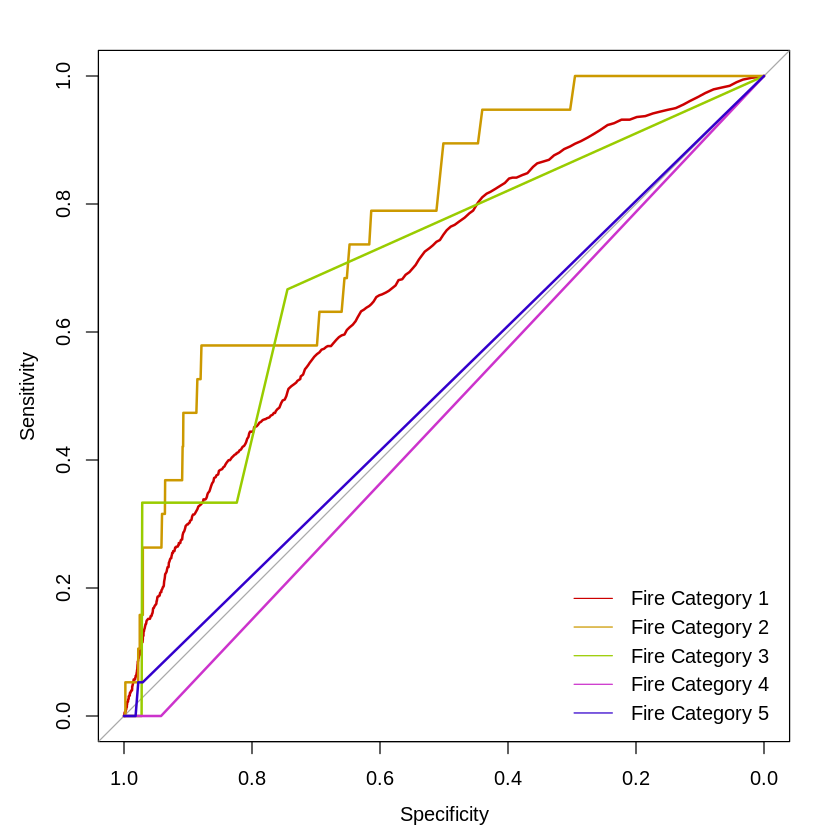

In [ ]:
plot(ran_roc$rocs[[1]],col='#cc0000')
ran_roc <- multiclass.roc(testtree$FireBand, roc.pred[,2])
plot.roc(ran_roc$rocs[[2]],add=TRUE,col='#cc9900')
ran_roc <- multiclass.roc(testtree$FireBand, roc.pred[,3])
plot.roc(ran_roc$rocs[[3]],add=TRUE,col='#99cc00')
ran_roc <- multiclass.roc(testtree$FireBand, roc.pred[,4])
plot.roc(ran_roc$rocs[[4]],add=TRUE,col='#cc33cc')
ran_roc <- multiclass.roc(testtree$FireBand, roc.pred[,5])
plot.roc(ran_roc$rocs[[5]],add=TRUE,col='#3300cc')

legend("bottomright", lty=1, cex=1, bty="n",
       c("Fire Category 1","Fire Category 2","Fire Category 3","Fire Category 4", "Fire Category 5"),
       col=c("#cc0000","#cc9900","#99cc00","#cc33cc","#3300cc"))
